# Landmark-based Registration

## Introduction
In this exercise, you will implement 3D rigid and affine image registration based on anatomical landmarks. You will work with a T1-weighted and a T2-weighted MRI scan of the same patient, where the patient is lying in a different position in the scanner between the two image acquisition (for the purpose of this exercise, the movement is simulated).

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

***Introduction***

In this report, we implement 3D rigid and affine image registration using anatomical landmarks. The task involves aligning two MRI scans of the same patient, acquired in different orientations, and then fitting the T2 scan onto the T1 scan’s image grid. The primary goal is to use anatomical landmarks for the registration process, followed by resampling the T2 image onto the T1 grid. Additionally, we explore the effects of both affine and rigid transformations for the alignment process.
We also investigate the challenges posed by voxel size differences in the images, which can lead to poor alignment results. This report details the complete implementation and the results of both registration methods, followed by a discussion on the challenges and possible improvements.

Key Concepts:

-⁠ ⁠Voxel and World Coordinates: MRI images are typically represented as 3D arrays of voxels, with voxel indices representing positions in image space. However, each voxel also corresponds to a real-world coordinate, represented by the image’s affine transformation matrix. This matrix converts between voxel coordinates and real-world coordinates. Registration works by transforming these world coordinates between two images so that corresponding anatomical features would eventually align.

-⁠ ⁠Affine transformation is a general linear transformation, which can involve translation, rotation, scaling. This transformation can warp the image in complex ways but is necessary when there are differences in the patient’s positioning or scaling between scans. Rigid transformation, on the other hand, only allows translation and rotation, preserving the shape and distances between points in the image. It is often sufficient for simple alignment when no scaling or ofsetting is involved.

-⁠ ⁠Landmark-Based Registration: This method relies on selecting corresponding anatomical landmarks (specific points) in both images. By solving for a transformation matrix that minimizes the distance between corresponding landmarks, we can align the two images. The more accurate and well-distributed the landmarks, the better the registration result.

### Input data and code hints
Import Python libraries:

In [437]:
import matplotlib.pyplot as plt
# matplotlib notebook
plt.ion()
import numpy as np
np.set_printoptions( suppress=True )
import nibabel as nib
import scipy

Read the two 3D scans you'll be working with in this exercise:

In [438]:
# Load T1 and T2 data
T1_fileName = '/Users/xixiwang/Desktop/DTUcoures/MIA-main/exercises/ex2/IXI014-HH-1236-T1.nii'
T2_fileName = '/Users/xixiwang/Desktop/DTUcoures/MIA-main/exercises/ex2/IXI014-HH-1236-T2_moved.nii'
T1 = nib.load( T1_fileName )
T2 = nib.load( T2_fileName )
T1_data = T1.get_fdata()
T2_data = T2.get_fdata()




Below is code to define a simple interactive viewer class that can be used to visualize 2D cross-sections of a 3D array along three orthogonal directions. It takes a 3D volume as input and shows the location a "linked cursor" in all three cross-sections.

In [439]:
class Viewer:
    def __init__(self, data ):
        self.fig, self.ax = plt.subplots()
        self.data = data
        self.dims = self.data.shape
        self.position = np.round( np.array( self.dims ) / 2 ).astype( int )
        self.draw()
        self.fig.canvas.mpl_connect( 'button_press_event', self )
        self.fig.show()

    def __call__(self, event):
        print( 'button pressed' )
        if event.inaxes is None: return
      
        x, y = round( event.xdata ), round( event.ydata )

        #
        if ( x > (self.dims[0]-1) ) and ( y <= (self.dims[1]-1) ): return # lower-right quadrant
          
        #
        if x < self.dims[0]:
          self.position[ 0 ] = x
        else:
          self.position[ 1 ] = x - self.dims[0]
        
        if y < self.dims[1]:
          self.position[ 1 ] = y
        else:
          self.position[ 2 ] = y -self.dims[1]
        
        print( f"  voxel index: {self.position}" )
        print( f"  intensity: {self.data[ self.position[0], self.position[1], self.position[2] ]}" )

        self.draw()

    def draw( self ):
        #
        # Layout on screen is like this:
        #
        #     ^            ^
        #  Z  |         Z  |
        #     |            |
        #     ----->        ---->  
        #       X             Y
        #     ^
        #  Y  |
        #     |
        #     ----->  
        #       X
        #
        dims = self.dims
        position = self.position
        
        xySlice = self.data[ :, :, position[ 2 ] ]
        xzSlice = self.data[ :, position[ 1 ], : ]
        yzSlice = self.data[ position[ 0 ], :, : ]
        
        kwargs = dict( vmin=self.data.min(), vmax=self.data.max(), 
                       origin='lower', 
                       cmap='gray',
                       picker=True )

        self.ax.clear()

        self.ax.imshow( xySlice.T, 
                        extent=( 0, dims[0]-1, 
                                 0, dims[1]-1 ), 
                        **kwargs )
        self.ax.imshow( xzSlice.T, 
                        extent=( 0, dims[0]-1, 
                                 dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )
        self.ax.imshow( yzSlice.T, extent=( dims[0], dims[0]+dims[1]-1, 
                                            dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )

        color = 'g'
        self.ax.plot( (0, dims[0]-1), (position[1], position[1]), color )
        self.ax.plot( (0, dims[0]+dims[1]-1), (dims[1]+position[2], dims[1]+position[2]), color )
        self.ax.plot( (position[0], position[0]), (0, dims[1]+dims[2]-1), color )
        self.ax.plot( (dims[0]+position[1], dims[0]+position[1]), (dims[1]+1, dims[1]+dims[2]-1), color )

        self.ax.set( xlim=(1, dims[0]+dims[1]), ylim=(0, dims[1]+dims[2]) )

        self.ax.text( dims[0] + dims[1]/2, dims[1]/2, 
                      f"voxel index: {position}",  
                      horizontalalignment='center', verticalalignment='center' )
  
        self.ax.axis( False )

        self.fig.canvas.draw()

The code below shows how to visualize the T1-weigthed and the T2-weighted volumes with this viewer class. The initial location of the cursor is in the middle of the volume in each case. It can be changed by clicking on one of the cross-sections. The viewer also displays the voxel index $\mathbf{v}$ of the cursor. Play around and try to understand what the Viewer() class does.

/var/folders/89/n7z9_hx13xg6jcy_80f9yj900000gn/T/ipykernel_83707/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


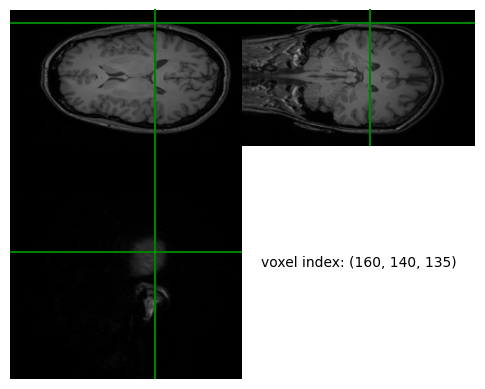

In [440]:

T1_viewer = Viewer( T1_data )
T1_viewer.position=(160,140,135)
T1_viewer.draw()

/var/folders/89/n7z9_hx13xg6jcy_80f9yj900000gn/T/ipykernel_83707/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


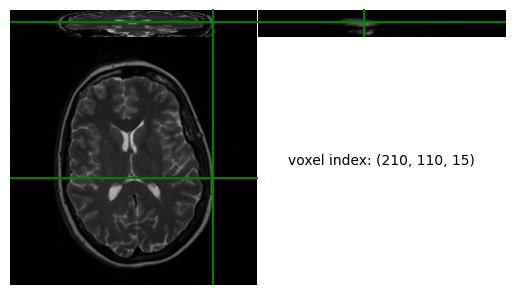

In [441]:

T2_viewer = Viewer( T2_data )
T2_viewer.position=(210,110,15)
T2_viewer.draw()

### Task 1: Coordinate Systems

Familiarize yourself with the concept of coordinate systems. In your report, explain why we need to differentiate between "voxel coordinates/indices" $\mathbf{v}$ and "world coordinates" $\mathbf{x}$. Why does the T2-weighted volume look so compressed in the viewer? For the enthusiastic student: calculate the voxel size in each dataset.

The world coordinate system used in both the T1-weighted and the T2-weighted scan follows the RAS convention. Equipped with this information, determine the voxel index $\mathbf{v}$ of the center of the left eye of the patient in the T1-weighted scan. Do the same for the T2-weighted scan.
 
> ***Hints:***
> 
> - The affine voxel-to-world matrix of the T1-weighted scan is given by
>
>        T1.affine
>
> 
> - In nibabel, the RAS convention is used (see bottom of https://nipy.org/nibabel/coordinate_systems.html)



In [442]:

print(T1.affine@(np.append(np.array([60,100,75]), 1)))
# T1_viewer.position = (60, 100, 75)  # Set position to a chosen landmark in T1
# T1_viewer.draw()
print(T2.affine@(np.append(np.array([60,100,75]), 1)))

[ -0.59859834  75.98252577 -19.97698552   1.        ]
[ 10.10890037  -8.62961388 301.89501193   1.        ]


Voxel coordinates refer to the indices within the 3D volume of the image. World coordinates represent the physical position of each voxel in the real world, which is dependent on the scanner’s orientation and voxel size.

To answer why the T2-weighted volume looks compressed is because it could be due to differences in voxel sizes between the two scans. The voxel size can be obtained from the T1.affine and T2.affine matrices, which map voxel coordinates to world coordinates.

### Task 2: Resample the T2-weighted scan to the image grid of the T1-weighted scan

In this task you should resample the T2-weighted scan to the image grid of the T1-weighted scan, i.e., create a new 3D volume that has the same size as the T1-weighted volume, but that contains interpolated T2-weighted intensities instead. In particular, for each voxel index $\mathbf{v}_{T1}$ in the T1-weighted image grid, you should compute the corresponding voxel index $\mathbf{v}_{T2}$ in the T2-weighted volume as follows (see section 2.1 in the book):
$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
.
$$
At the location $\mathbf{v}_{T2}$, you should then use cubic B-spline interpolation to determine the intensity in the T2-weighted scan, and store it at index $\mathbf{v}_{T1}$ in the newly created image.

Once you have created a new volume like this, visualize it overlaid on the T1-weighted volume as follows:
    
    Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )

> ***Hints:***
> - you can create a coordinate grid in 3D with the function
> 
>        V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), 
>                                np.arange( T1_data.shape[1] ), 
>                                np.arange( T1_data.shape[2] ), indexing='ij' )
>   
>
> - the following SciPy function interpolates the T2-weighted volume at voxel coordinates $(1.1,2.2,3.3)^T$ 
> and $(6.6,7.7,8.8)^T$ using cubic interpolation:   
>
>        scipy.ndimage.map_coordinates( T2_data, np.array( [ [1.1,2.2,3.3], [6.6,7.7,8.8] ] ).T )
>

In [443]:


V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ),  np.arange( T1_data.shape[1] ),  np.arange( T1_data.shape[2] ), indexing='ij' )
M_T1 = T1.affine
M_T2 = T2.affine  # 4x4 matrix for T2-weighted image

# Inverse of the T2 affine matrix
M_T2_inv = np.linalg.inv(M_T2)

# Stack the voxel coordinates into a 4xN array (homogeneous coordinates)
voxel_coords_T1 = np.vstack((V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)))

# Transform the coordinates from the T1 to the T2 space
voxel_coords_T2 = np.dot(M_T2_inv, np.dot(M_T1, voxel_coords_T1))

# Extract the 3D voxel coordinates in the T2-weighted space
v_T2_1 = voxel_coords_T2[0, :]
v_T2_2 = voxel_coords_T2[1, :]
v_T2_3 = voxel_coords_T2[2, :]
T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, [v_T2_1, v_T2_2, v_T2_3], order=3).reshape(T1_data.shape)


/var/folders/89/n7z9_hx13xg6jcy_80f9yj900000gn/T/ipykernel_83707/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


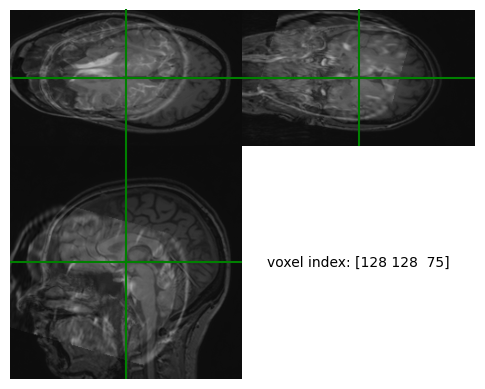

In [444]:
Viewer(T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max())


### Task 3: Collect corresponding landmarks

Using the viewer class, record the voxel coordinates $\mathbf{v_{T1}}$ and $\mathbf{v_{T2}}$ of at least five corresponding landmarks in the T1- and the T2-weighted volumes, respectively. List them in your report, and explain why you picked them. 

> ***Hint:***
> - Avoid picking landmarks that are very close to each other or that all lie approximately in the same 2D plane.
> - You can double-check which landmarks you've selected as follows:
>         T1_viewer = Viewer( T1_data )
>         T1_viewer.position = ( 20, 30, 40 )
>         T1_viewer.draw()
> 


For this task, we have chosen the following landmarks in the T1 and T2 images:

•⁠  ⁠*Top of the head*
•⁠  ⁠*Both sides of the head (edges)*
•⁠  ⁠*Both eyes*
•⁠  ⁠*Back of the head*
•⁠  ⁠*Nose*
•⁠  ⁠*Chin*

These landmarks were selected because they are easily identifiable in both T1 and T2 scans, and they provide a good spatial distribution across different regions of the head. 

•⁠  ⁠*Top of the head*: This is a highly distinctive and prominent landmark that helps align. It could provide an important reference for the vertical alignment of the scans.
    
•⁠  ⁠*Both sides of the head (edges)*: The landmarks on the left and right sides of the head are chosen to ensure that the lateral dimensions (the width of the head) are correctly aligned in both scans. This could prevent tilting or horizontal misalignment of the head between the two images.
    
•⁠  ⁠*Both eyes*: The eyes are symmetric and easily identifiable anatomical structures, aligning the eyes ensures proper alignment of facial features, particularly in the front part of the head.
    
•⁠  ⁠*Back of the head*: This landmark ensures also that the posterior part of the skull is correctly aligned. It is especially important for adjusting the depth alignment of the scans.
    
•⁠  ⁠*Nose*: The nose is a prominent external feature located at the center of the face, which helps also in the alignment of the central facial features in the front-to-back dimension.
    
•⁠  ⁠*Chin*: The chin, located in the lower region of the face, ensures that the lower part of the skull is also aligned properly. It aids in adjusting the vertical alignment of the lower face.

![Screenshot 2024-09-30 at 20.42.15.png](<attachment:Screenshot 2024-09-30 at 20.42.15.png>)
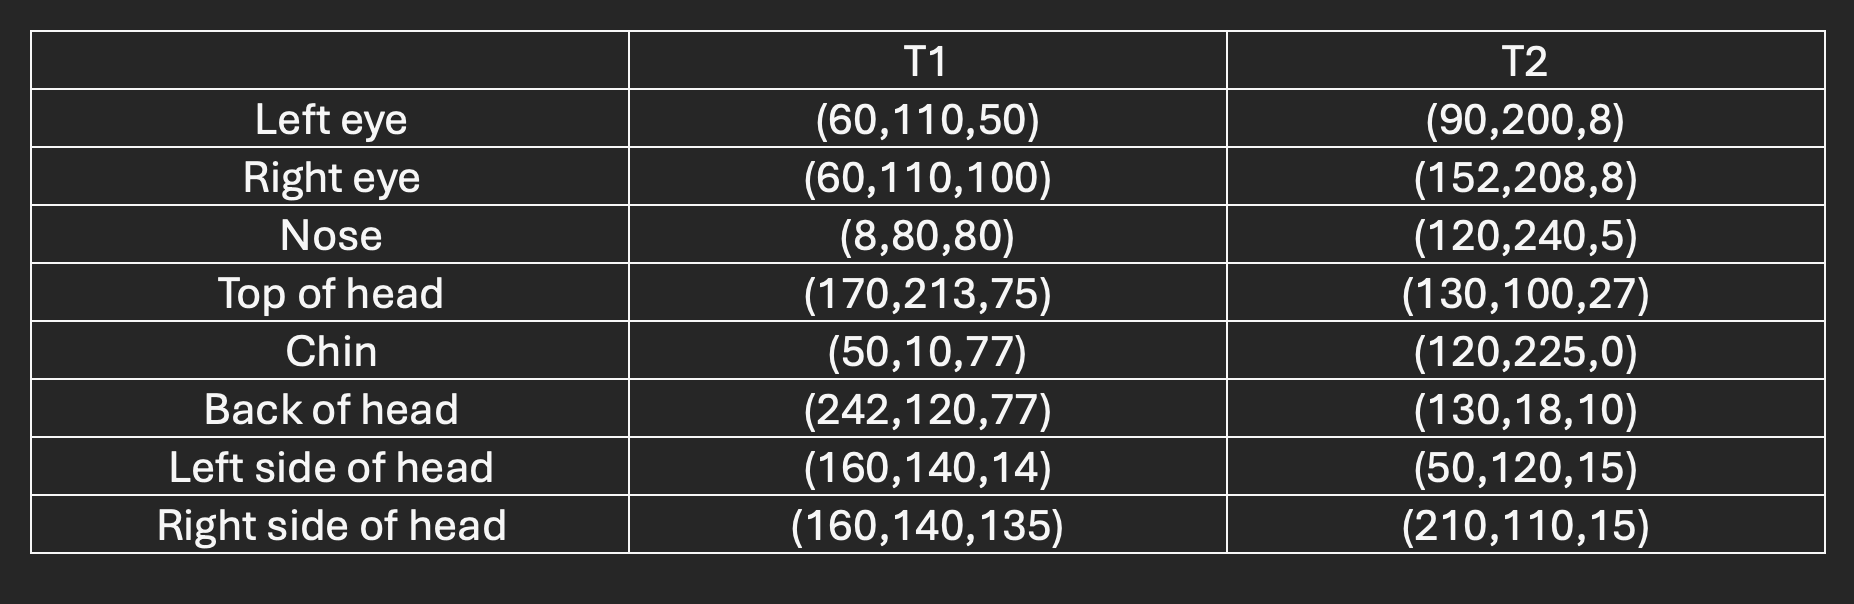

/var/folders/89/n7z9_hx13xg6jcy_80f9yj900000gn/T/ipykernel_83707/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


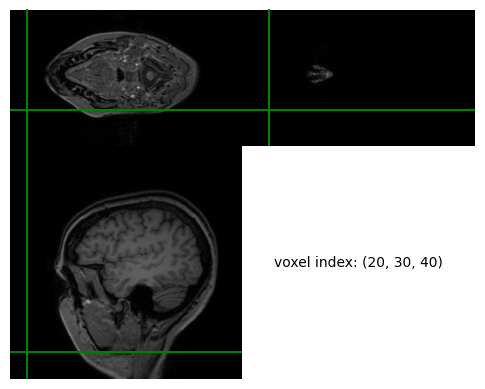

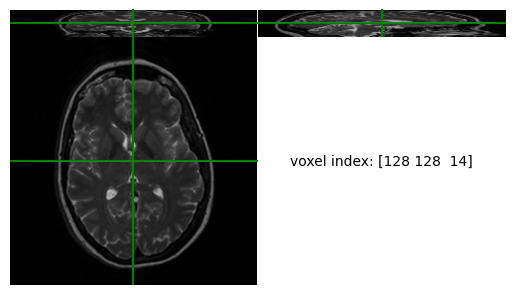

In [445]:

T1_viewer = Viewer(T1_data)
T2_viewer = Viewer(T2_data)
T1_viewer.position = (20, 30, 40)  
T2_viewer.position = (22, 32, 42)  
T1_viewer.draw()
T2_viewer.draw()


### Task 4: Perform affine landmark-based registration 

Using the landmarks you recorded in the previous task, compute the parameters of the 3D affine transformation that brings the landmarks in the T1-weighted image closest to the corresponding ones in the T2-weighted image. For this purpose, use Equation (2.8) in the book.

Once you've determined the affine transformation, register to two images by resampling the T2-weighted image to the image grid of the T1-weighted image, and overlay the two images as in Task 2. To map voxel coordinates $\mathbf{v}_T1$ to $\mathbf{v}_T2$, you'll have to use 
$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
,
$$
where $\mathbf{M}$ is your $4 \times 4$ affine matrix (see book).

What happens when you increase/decrease the number of corresponding landmarks that are used in the computations? Comment.

> ***Hint:***
> - remember that the affine matrix works in *world* coordinates, so you'll have to map your landmarks to world coordinates first.
> - you can use  
>
>       np.hstack() 
>
>   to append a column of ones to an existing matrix (e.g., to construct the $\mathbf{X}$ matrix in Equation (2.8) in the book).
>

[[  0.   0.   0. ... 255. 255. 255.]
 [  0.   0.   0. ... 255. 255. 255.]
 [  0.   1.   2. ... 147. 148. 149.]
 [  1.   1.   1. ...   1.   1.   1.]]
[[  0.05389359  -0.95136534   0.00632193   0.        ]
 [  0.04252762  -0.01943297   0.12640657  -0.        ]
 [  1.30748897  -0.05667059  -0.00037675   0.        ]
 [ 14.84381886 267.39185099  -4.14964399   1.        ]]
[[ 14.84381886  16.15130783  17.4587968  ... 231.63210471 232.93959367
  234.24708264]
 [267.39185099 267.33518039 267.2785098  ...  11.50770573  11.45103514
   11.39436454]
 [ -4.14964399  -4.15002074  -4.1503975  ...  29.64074008  29.64036333
   29.63998657]
 [  1.           1.           1.         ...   1.           1.
    1.        ]]


/var/folders/89/n7z9_hx13xg6jcy_80f9yj900000gn/T/ipykernel_83707/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


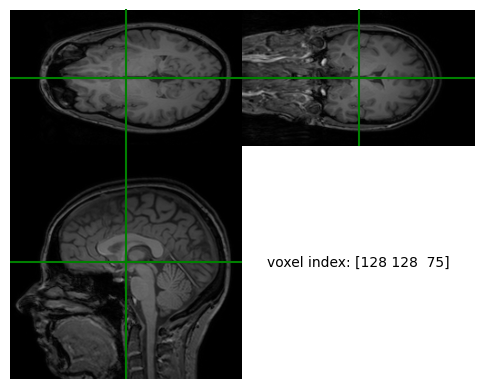

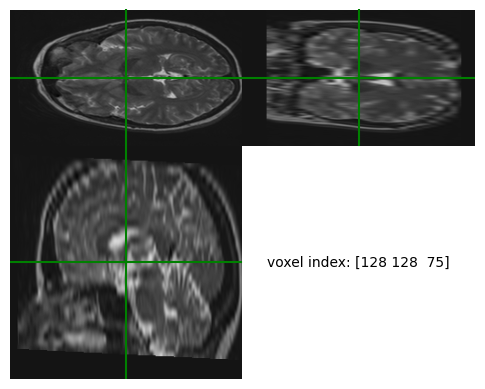

In [446]:

# Example with numpy to append ones to the X matrix
landmarks_T1 = np.array([[60,110,50], [60,110,100], [8,80,80], [170,213,75], [50,10,77],[242,120,77],[160,140,14 ],[160,140,135]])  # Example
landmarks_T2 = np.array([[90,200,8], [152,208,8], [120,240,5], [130,100,27], [120,225,1],[130,18,10],[50,120,15],[210,110,15]])  # Example


X_T1 = np.hstack([landmarks_T1, np.ones((landmarks_T1.shape[0], 1))])
# X_T2=landmarks_T2
X_T2=np.hstack([landmarks_T2, np.ones((landmarks_T2.shape[0], 1))])

# Compute the affine transformation matrix M
M,_,_,_ = np.linalg.lstsq(X_T1, X_T2,rcond=None)
V1, V2, V3 = np.meshgrid(np.arange(T1_data.shape[0]), 
                         np.arange(T1_data.shape[1]), 
                         np.arange(T1_data.shape[2]), indexing='ij')

T1_voxel_grid = np.array([V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)])
# Transform T1 voxel grid to T2 coordinates using the affine matrix

T2_voxel_grid = M.T@T1_voxel_grid
print(T1_voxel_grid)
print(M)
print(T2_voxel_grid)

# Interpolate intensities from T2 at the transformed positions

T2_resampled = scipy.ndimage.map_coordinates(T2_data, T2_voxel_grid[:3], order=3).reshape(T1_data.shape)
# Viewer(T2_resampled / T2_resampled.max() + T1_data / T1_data.max())
Viewer(T1_data / T1_data.max())
Viewer(T2_resampled / T2_resampled.max() )

### Task 5: Perform rigid landmark-based registration 

Repeat Task 4, but this time using a *rigid* transformation model. Vary the number of landmarks that are used again, and comment. Which transformation model (affine or rigid) is more appropriate to use in this specific application?

> ***Hint:***
> - a singular value decomposition can be computed using
>           
>          np.linalg.svd()
>
> - the determinant of a matrix can be computed using
>    
>         np.linalg.det()
>


[ 44.86111518 299.54258531  74.20672041]


/var/folders/89/n7z9_hx13xg6jcy_80f9yj900000gn/T/ipykernel_83707/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


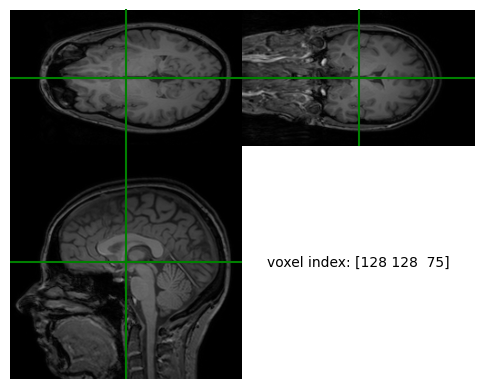

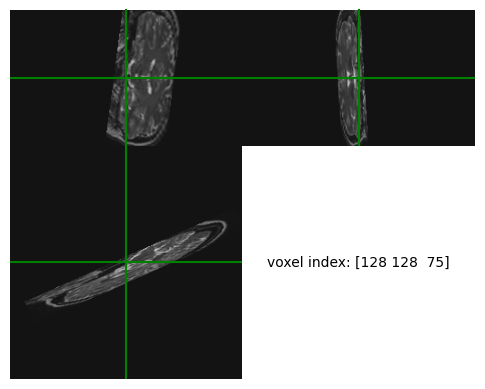

In [447]:
t1_data=T1_data
t2_data=T2_data


def compute_rigid_transformation(landmarks_T1, landmarks_T2):
    centroid_T1 = np.mean(landmarks_T1, axis=0)
    centroid_T2 = np.mean(landmarks_T2, axis=0)
    
    # Subtract centroids from landmarks to center them
    centered_T1 = landmarks_T1 - centroid_T1
    centered_T2 = landmarks_T2 - centroid_T2
    
    # Compute the covariance matrix
    H = np.dot(centered_T1.T, centered_T2)
    
    # Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(H)
    
    # Compute the rotation matrix
    R = np.dot(Vt.T, U.T)

    
    # # Ensure a proper rotation (no reflection)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)
    
    # Compute the translation vector
    t = centroid_T2 - np.dot(R, centroid_T1)
    
    return R, t

# Step 2: Apply the rigid transformation
def apply_rigid_transformation(R, t, voxel_grid):
    # Apply the rotation and translation to the voxel grid
    print(t)
    transformed_voxel_grid = np.dot(R, voxel_grid[:3, :]) + t[:, np.newaxis]
    return transformed_voxel_grid

# Let's recompute the transformation using a rigid model this time
R, t = compute_rigid_transformation(landmarks_T1, landmarks_T2)

# Prepare the voxel grid for T1 (3D coordinates)
T1_voxel_grid = np.array([V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)])

# Apply the rigid transformation to the voxel grid
T2_voxel_grid_rigid = apply_rigid_transformation(R, t, T1_voxel_grid)

# Interpolate intensities from T2 at the transformed positions
T2_resampled_rigid = scipy.ndimage.map_coordinates(t2_data, T2_voxel_grid_rigid, order=3).reshape(t1_data.shape)

# Normalize and overlay images
overlay_image_rigid = T2_resampled_rigid / T2_resampled_rigid.max() + t1_data / t1_data.max()
# Viewer(overlay_image_rigid)
Viewer(T1_data / T1_data.max())
Viewer(T2_resampled_rigid / T2_resampled_rigid.max() )


***Conclusion***

In this report, we implemented 3D landmark-based registration to align a T2 MRI scan to a T1 scan using both affine and rigid transformation models. While the affine transformation provided flexibility by allowing movement, the rigid transformation preserved the geometric relationships between landmarks, resulting in a less distorted registration. Through the resampling process, we overlaid the T2 image on the T1 image to assess the accuracy of the registration.

However, the result was not as accurate as expected. One contributing factor was the difference in voxel sizes between the two scans, especially along the z-axis, where the T1 image had 150 slices and the T2 image only had 28 slices. This discrepancy led to some degree of misalignment in the overlap. Additionally, having more landmarks would have improved the accuracy of the registration, as a larger number of well distributed points would reduce the error caused by small discrepancies in landmark selection.

In future work, using a higher number of landmarks and better landmark selection could help mitigate these issues and provide more accurate registration results. Additionally, pre-processing steps like resampling the z-axis of the T2 image to match the T1 image might improve the alignment quality.